In [1]:
"""
    Requirements to execute code
"""

"""
! pip install nltk
! pip install mtcnn
! pip install cv2
! pip install keras
! pip install numpy
! pip install pandas
! pip install cv2
! pip install regex
"""

'\n! pip install nltk\n! pip install mtcnn\n! pip install cv2\n! pip install keras\n! pip install numpy\n! pip install pandas\n! pip install cv2\n! pip install regex\n'

In [73]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize']  = (10, 8)
plt.rcParams['axes.labelsize']  = 10
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (10, 8)

# **Comparando modelos para classificar a imagem**

In [5]:
"""
    Importing Pre-Trained  face recognition model.
    Font article : https://github.com/atulapra/Emotion-detection/blob/master/ResearchPaper.pdf
"""

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.load_weights('model/model.h5')   

path = 'fairface-img-margin125-trainval/train/'
images_list = os.listdir(path)

emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

dictResult = {}
resultImage = {}
i = 0

for file in images_list:
    nameFile = path+file
    
    if i % 1000 == 0:
        print("{}/{}- file:{}".format(i,len(images_list),nameFile))

    face_image  = cv2.imread(nameFile)
    face_image = cv2.resize(face_image, (48,48))
    face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
    face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])

    predicted_class = np.argmax(model.predict(face_image))
    predicted_label = emotion_dict [predicted_class]
    
    if predicted_label in dictResult:
        dictResult[predicted_label] += 1
    else:
        dictResult.update({predicted_label: 1})
        
    resultImage.update({file: predicted_label})
    

    i += 1

# ALL: {'Angry': 9376, 'Sad': 17019, 'Happy': 24401, 'Fear': 22127, 'Disgust': 39, 'Neutral': 8428, 'Surprise': 5354}
# 1000 : {'Angry': 109, 'Sad': 217, 'Happy': 274, 'Fear': 246, 'Disgust': 1, 'Neutral': 90, 'Surprise': 63}

0/86744- file:fairface-img-margin125-trainval/train/1.jpg
1000/86744- file:fairface-img-margin125-trainval/train/10899.jpg


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-95d77e3525ea>", line 47, in <module>
    predicted_class = np.argmax(model.predict(face_image))
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1462, in predict
    callbacks=callbacks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training_arrays.py", line 324, in predict_loop
    batch_outs = f(ins_batch)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\keras\backend.py", line 3740, in __call__
    outputs = self._graph_fn(*converted_inputs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\eager\function.py", line 1081, in __call__
    return self._call_impl(args, kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\eager\function.py",

KeyboardInterrupt: 

## Exploratory Data Analisys

### Merge data frames

In [ ]:
# Dataframe of labels
df = pd.read_csv('label/fairface_label_train.csv')
df.loc[:,"file"] = [x.replace('train/',"") for x in df.loc[:,"file"]]

data = {'file':list(resultImage.keys()), 'emotions':list(resultImage.values())}

# Dataframe of result
df_result = pd.DataFrame(data=data, columns=['file', 'emotions'])

# Join two files
df = pd.merge(df_result, df, how="outer", on="file")
df.head(5)

In [ ]:
# Saves result to your used later
df.to_csv('label/emotions-fairface.csv')

In [6]:
# Importing result images classification 
df = pd.read_csv('label/emotions-fairface.csv', index_col=0)
df.head(5)

,file,emotions,age,gender,race,service_test
0,1.jpg,Angry,50-59,Male,East Asian,True
1,10.jpg,Sad,30-39,Male,Middle Eastern,False
2,100.jpg,Happy,20-29,Female,East Asian,False
3,1000.jpg,Fear,30-39,Male,White,False
4,10000.jpg,Happy,50-59,Male,White,False


### Function for merge columns categories

In [47]:
def mergeForPlot(df, colName):
    # Define labels for aixes X
    emotions_list = list(df['emotions'].unique())

    # Set of ages
    labels = set(df[colName])
    
    # Define empty dataframe
    df_merge = pd.DataFrame({})

    for label in labels:

        # Group for age 
        exp = colName+' == "'+label +'"'
        data = df.query(exp)
        data = data[["emotions","count"]]
        data.columns = ["emotions","count "+label]

        if df_merge.shape[0] == 0:
            df_merge = data
        else:
            df_merge = pd.merge(df_merge,data, on="emotions", how ="outer")
    
    return df_merge

### Emotions for gender

In [90]:
df_gender = df.groupby(["emotions", "gender"], as_index=False).sum()
df_gender.columns = ["emotions", "gender", "count"]

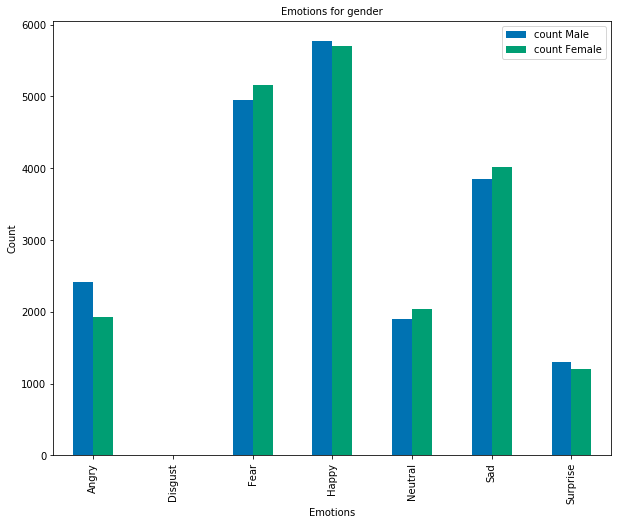

In [106]:
emotions_list = list(gender['emotions'].unique())

df_merge = mergeForPlot(df_gender,'gender')
plotResult = df_merge.plot.bar().set(
    xticklabels=emotions_list,
    title="Emotions for gender",
    xlabel='Emotions',
    ylabel="Count"
)

### Emotions for races

In [75]:
df_race = df.groupby(["emotions", "race"], as_index=False).sum()
df_race.columns = ["emotions", "race", "count"]

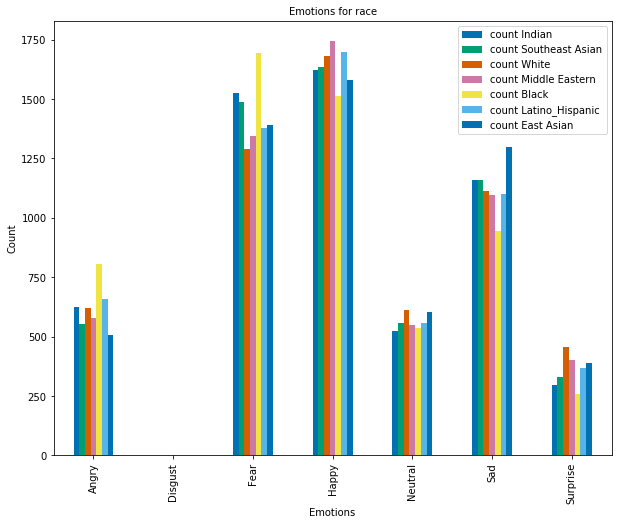

In [105]:
emotions_list = list(df_race['emotions'].unique())

df_merge = mergeForPlot(df_race,'race')
plotResult = df_merge.plot.bar().set(
    xticklabels=emotions_list,
    title="Emotions for race",
    xlabel='Emotions',
    ylabel="Count"
)

### Emotions for age

In [77]:
df_age = df.groupby(["emotions", "age"], as_index=False).sum()
df_age.columns = ["emotions", "age", "count"]

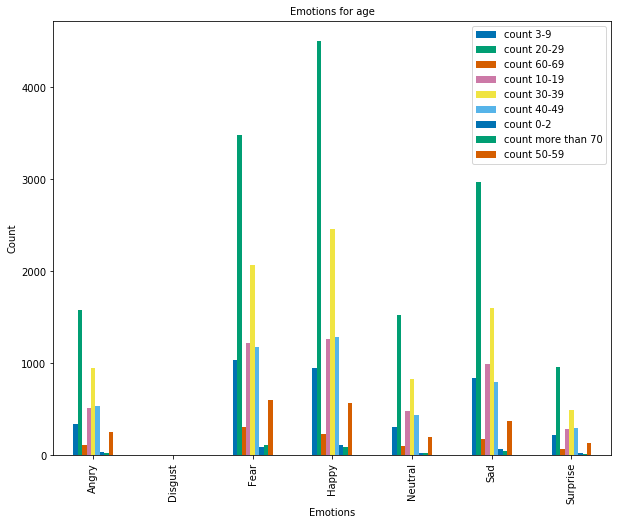

In [103]:
emotions_list = list(df_age['emotions'].unique())

df_merge = mergeForPlot(df_age,'age')
plotResult = df_merge.plot.bar().set(
    xticklabels=emotions_list,
    title="Emotions for age",
    xlabel='Emotions',
    ylabel="Count"
)

### Emotions for age and gender

In [79]:
df_age_gender = df.groupby(["emotions", "age", "gender"], as_index=False).sum()
df_age_gender.columns = ["emotions", "age", "gender","count"]

#### Gender: male

In [80]:
df_male = df_age_gender.query("gender == 'Male'")
df_female = df_age_gender.query("gender == 'Female'")

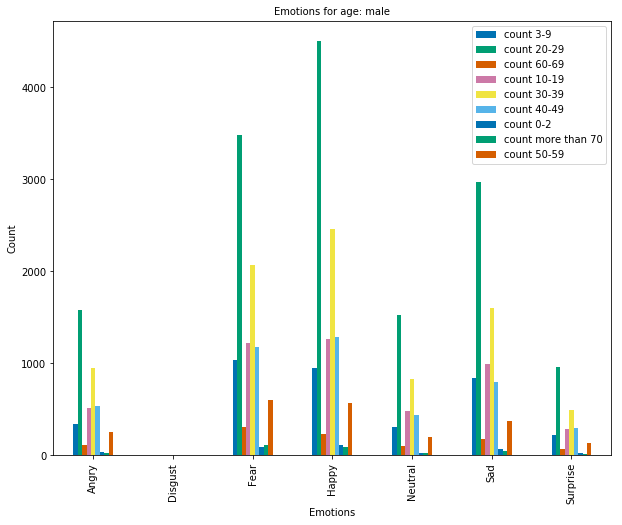

In [98]:
emotions_list = list(df_female['emotions'].unique())

df_merge = mergeForPlot(df_age,'age')
plotResult = df_merge.plot.bar().set(
    xticklabels=emotions_list,
    title="Emotions for age: male",
    xlabel='Emotions',
    ylabel="Count"
)

#### Gender: female

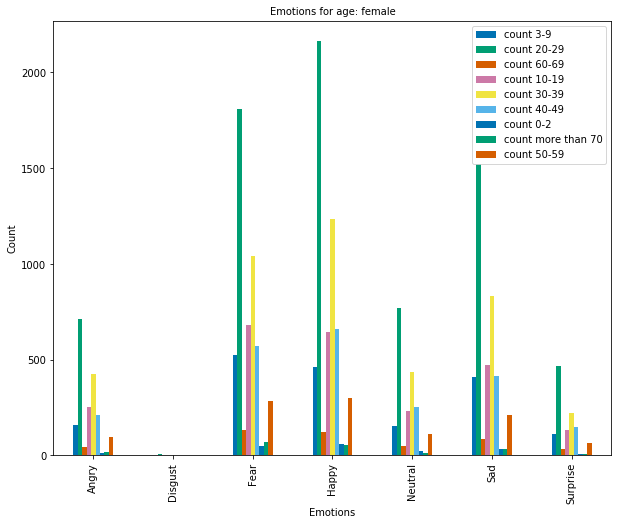

In [97]:
emotions_list = list(df_female['emotions'].unique())

df_merge = mergeForPlot(df_female,'age')
plotResult = df_merge.plot.bar().set(
    xticklabels=emotions_list,
    title="Emotions for age: female",
    xlabel='Emotions',
    ylabel="Count"
)